In [2]:
!pip install monai
!pip install nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.9 MB/s eta 0:00:00


In [3]:
!curl -L -o ./oasis-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/pulavendranselvaraj/oasis-dataset && unzip oasis-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_124.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_125.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_126.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_127.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_128.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_129.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_130.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_131.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_132.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_133.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_134.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_135.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_136.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_137.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_138.jpg  
  inflating: input/

# DEMENTIA CLASSIFICATION: A COMPARATIVE ANALYSIS USING DEEP LEARNING TECHNIQUES

### IMPORTING THE REQUIRED LIBRARIES

In [1]:
# These are pytorch imports for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor, transforms
import torchvision.models as models
import nibabel as nib  # Use nibabel for 3D medical images
import torch.optim.lr_scheduler as lr_scheduler
from tqdm.auto import tqdm
import os
import math
import random
import numpy as np
from PIL import Image
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
warnings.filterwarnings("ignore")

In [ ]:
import monai.transforms as monai_transforms # for medical transformations

In [ ]:
# path to the dataset
root_dir =  "C:/Users/Hp/Documents/ezeikel_dataset/input/"

### CREATING A CUSTOM DATASET CLASS

In [ ]:
class DementiaDataset(Dataset):
    """A dataset class for dementia classification using medical images (2D or 3D).
    It reads images, applies transformations, and provides samples with labels."""

    def __init__(self, root_dir, transform=None, weights=None, augment=False, is_3d=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_3d = is_3d
        self.image_paths = [str(i) for i in Path(self.root_dir).rglob("*.nii.gz" if is_3d else "*.jpg")]
        self.labels = [Path(i).parent.name for i in self.image_paths]
        self.classes = sorted(set(self.labels))
        self.class2idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.labels = [self.class2idx[label] for label in self.labels]
        self.augment = augment

        # Define augmentations
        if self.augment:
            self.augmentation = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip()
            ])
        else:
            self.augmentation = None

    def __len__(self):
        """Returns the length of the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Loads and returns an image and its corresponding label."""
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        if self.is_3d:
            # Load a 3D image (e.g., MRI scan)
            image = nib.load(image_path).get_fdata()  # Load the 3D NIfTI image
            image = self.spatial_normalization(image)  # Normalize spatial dimensions
        else:
            # Load a 2D image (e.g., JPEG)
            image = Image.open(image_path).convert("L")  # Grayscale image

        if self.augment and self.augmentation is not None:
            image = self.augmentation(image)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def noise_reduction(self, image):
        """Applies Gaussian smoothing to the image for noise reduction."""
        noise_reduction = monai_transforms.GaussianSmooth(sigma=1.0)
        return noise_reduction(image)

    def skull_stripping(self, image):
        """Applies a skull-stripping method using a threshold."""
        skull_strip_threshold = 0.1
        image[image < skull_strip_threshold] = 0
        return image

    def spatial_normalization(self, image):
        """Normalizes the spatial dimensions of 3D medical images to a standard size."""
        resize_transform = monai_transforms.Resize(spatial_size=(128, 128, 128))  # Resize 3D image
        return resize_transform(image)

    def segmentation(self, image):
        """Performs basic brain tissue segmentation (gray matter, white matter)."""
        gray_matter_min_threshold = 0.3
        white_matter_min_threshold = 0.6
        segmented_image = np.zeros_like(image)

        # Segment gray and white matter based on thresholds
        segmented_image[(image > gray_matter_min_threshold) & (image <= white_matter_min_threshold)] = 1  # Gray matter
        segmented_image[image > white_matter_min_threshold] = 2  # White matter
        return segmented_image

    def get_random_sample_for_classes(self):
        """Retrieves a random sample image for each class for visualization."""
        samples = []
        for cls, idx in self.class2idx.items():
            sample_idx = self.labels.index(idx)
            samples.append({
                "class": cls,
                "img_idx": sample_idx,
                "img_path": self.image_paths[sample_idx]
            })
        return samples

#### DEFINING TRANSFORMS

In [ ]:
# This is the pytorch convention of data augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize based on model and data
    transforms.RandomRotation(10),  # Small rotation for augmentation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale images
])

#### INITIALIZATIONS

In [ ]:
# the random seed aids repetition and production of deterministic results
RANDOM_SEED = 46
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# initialization of default training unit to CPU if GPU is not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

In [ ]:
# initializing the custom dataset class to load the dataset
dataset = DementiaDataset(root_dir=root_dir,
                          transform=transform,
                          augment=True,
                          is_3d=False)

In [ ]:
class_labels = ['mild dementia', 'moderate dementia', 'non demented', 'very mild dementia']

In [ ]:
# lenght of the dataset
len(dataset)

### VISUALIZATION

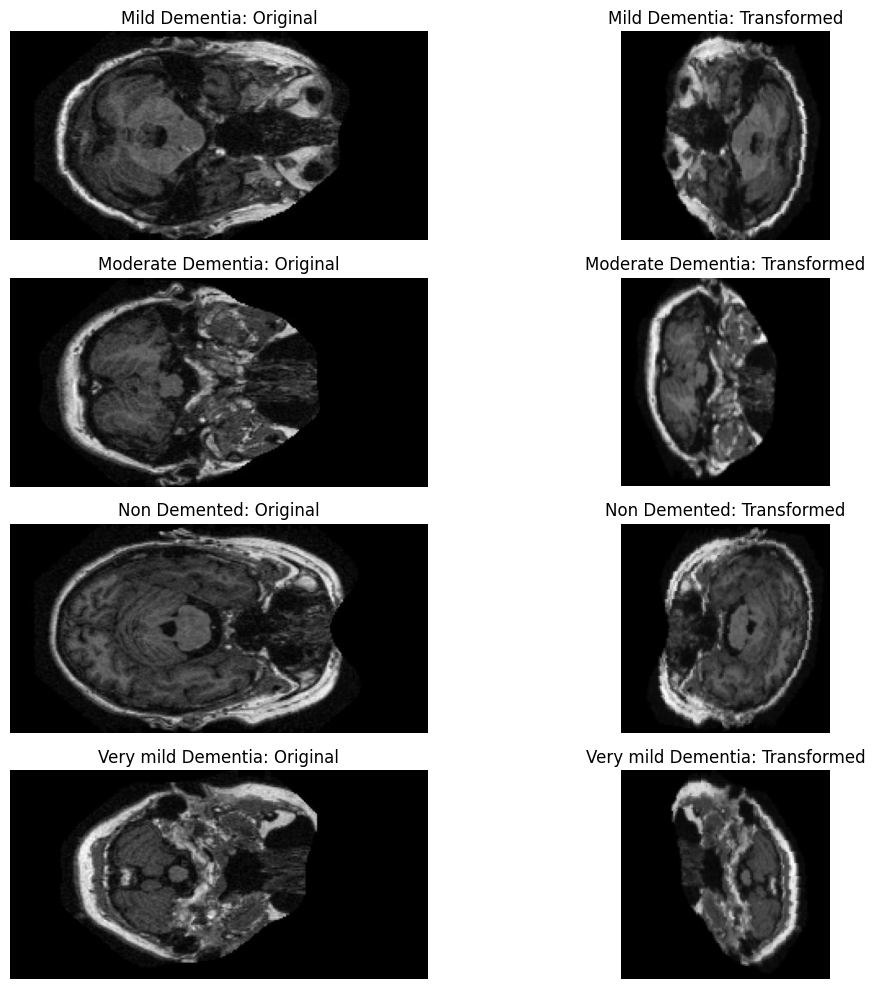

In [10]:
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image

# visualize the images and the transformed images
n_classes = len(dataset.classes)
grid_rows = math.ceil((n_classes * 2) / 4)  # Adjust grid to handle odd numbers

# Create a figure and axis for the grid of images
_, axes = plt.subplots(4 + n_classes % 4, grid_rows, figsize=(12, 10))
axes = axes.ravel()  # Flatten the axes array for easy indexing

samples = dataset.get_random_sample_for_classes()  # Get random samples for visualization

for i in range(0, len(axes), 2):
    # Ensure we don't exceed the number of available samples
    if i // 2 < len(samples):
        ax = axes[i]
        ax2 = axes[i + 1]

        sample = samples[i // 2]  # Get the sample (original image and class)

        # Original image
        original_image = np.array(Image.open(sample['img_path']).convert("L"))  # Corrected key 'img_path'
        ax.imshow(original_image, cmap='gray')
        ax.set_title(f'{sample["class"]}: Original')
        ax.axis('off')

        # Transformed image
        transformed_image, _ = dataset[sample['img_idx']]  # Retrieve transformed image from dataset
        transformed_image = transformed_image.numpy().transpose(1, 2, 0)  # Convert tensor to numpy array (H, W, C)
        ax2.imshow(transformed_image.squeeze(), cmap='gray')  # Remove singleton dimension if it's grayscale
        ax2.set_title(f'{sample["class"]}: Transformed')
        ax2.axis('off')

# Remove any empty subplots (in case the number of classes is odd)
for i in range(n_classes * 2, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


#### SPLITTIING THE DATASET USING RANDOM SPLIT FOR THE DATASET INSTANCE

In [11]:
# initialize the train size to 70% of the dataset while the 30% goes for testing and validation
train_size = int(0.7 * len(dataset))
test_val_size = len(dataset) - train_size

In [12]:
# implementing the 70-30% split using random split
train_dataset, test_val_dataset = random_split(dataset, [train_size, test_val_size])

In [13]:
# split (test_val_set) to get the percentage size for test and validation dataset
test_size = test_val_size // 2
val_size = test_val_size - test_size

In [14]:
# implementing the test-val size on the remaining 30% of the dataset to get the test dataset and validation dataset using random split
test_dataset, val_dataset = random_split(test_val_dataset, [test_size, val_size])#### DATALOADER IMPLEMENTATION

#### DATALOADER IMPLEMENTATION

In [15]:
# pytorch dataloader implementation for the train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              )

In [16]:
# pytorch dataloader implementation for the validation dataloader
val_dataloader = DataLoader(val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            )

In [17]:
# pytorch dataloader implementation for the test dataloader
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             )

In [18]:
# checking the shape
first_batch = next(iter(train_dataloader))

In [19]:
# checking the dimension of the dataloader
for batch_idx, (inputs, labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Input shape: {inputs.shape}, Labels shape: {labels.shape}")
    break

Batch 1:
Input shape: torch.Size([32, 1, 128, 128]), Labels shape: torch.Size([32])


In [20]:
inputs = first_batch

In [21]:
inputs[0][1].shape

torch.Size([1, 128, 128])

#### HYPERPARAMETERS

In [22]:
#number of input channels set to 1 for RGB images
in_channels = 1
#number of classes of fruit in dataset
num_classes = 4
#determines how much the model's weights are updated during each training step for resnet
learning_rate = 1e-5
#determines how much the model's weights are updated during each training step for cnn
learning_rate_c = 0.0003
#number of times the model was trained per cycle
NUM_EPOCHS = 20

### RESNET MODEL

In [23]:
class ResNet(nn.Module):
    """This class calls the resnet50 weight from the pytorch library for pretrained models, fine tunes it to suit
    the number of classes for our desired task then outputs the tuned model."""
    def __init__(self, num_classes):
        super(ResNet, self).__init__()

        # Load the pre-trained ResNet 50 model
        self.resnet = models.resnet50(pretrained=True)

        # Modify the first convolutional layer to accept a single channel
        self.resnet.conv1 = nn.Conv2d(
            in_channels=1,  # Grayscale images have 1 channel
            out_channels=self.resnet.conv1.out_channels,  # Keep the same number of output channels
            kernel_size=self.resnet.conv1.kernel_size,
            stride=self.resnet.conv1.stride,
            padding=self.resnet.conv1.padding,
            bias=self.resnet.conv1.bias is not None
        )

        # Allow gradient updates for all parameters in the model
        for param in self.resnet.parameters():
            param.requires_grad = True

        # Get the number of input features for the final fully connected layer
        in_features = self.resnet.fc.in_features

        # Replace the final fully connected layer with a new one
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

#### INSTANTIATE THE RESNET MODEL

In [24]:
model = ResNet(num_classes)

In [25]:
model.to(device)

ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

# LOSS FUNCTION AND OPTIMIZER FOR ALL MODEL TRAINING

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### RESNET TRAINING

In [ ]:
# The training loop is a pytorch convention, here the train and validation loaders are trained and tested using early stoppings
#Storing the loss and accuracy value for each epoch
r_train_losses = []
r_accuracy_values = []

# validation items
r_val_correct = 0
r_val_total = 0
r_val_losses = []
r_accuracy_val_values = []

# EARLY STOPPING PARAMETERS(Early stopping for managing overfitting)
patience = 5
best_val_loss = float("inf")
current_patience = 0

for epoch in range(NUM_EPOCHS):
    r_train_loss = 0.0
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    #initializing the prediction count to zero before the loop
    r_correct = 0
    r_total = 0
    for batch_idx, (inputs, labels) in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        #get data to cuda if possible
        inputs = inputs.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.long)

        # forward pass
        # optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #This code accumulates training loss, stores loss values for each batch
        r_train_loss += loss.item()
        r_train_losses.append(loss.item())

        # get prediction
        _, predicted = torch.max(outputs, dim=1)
        r_total += labels.size(0)
        r_correct += (predicted == labels).sum().item()

        #back propagation
        loss.backward()

        # gradient descent
        optimizer.step()
        optimizer.zero_grad()

    # update learning rate scheduler
    scheduler.step()

    train_loss = r_train_loss / len(train_dataloader)
    print('Epoch {} loss: {:.3f}'.format(epoch + 1, train_loss))
    r_train_accuracy = 100 * (r_correct / r_total)
    r_accuracy_values.append(r_train_accuracy)

    # validation loop
    model.eval()

    with torch.no_grad():
        r_val_loss = 0.0

        for batch_idx, (inputs, labels) in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
            inputs = inputs.to(device, dtype = torch.float32)
            labels = labels.to(device, dtype = torch.long)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # get loss
            r_val_loss += loss.item()

            # get prediction
            _, predicted = torch.max(outputs, dim=1)
            r_val_total += labels.size(0)
            r_val_correct += (predicted == labels).sum().item()

        # Calculate the average validation loss after the loop
        r_val_loss /= len(val_dataloader)

        # Check improvement
        if r_val_loss < best_val_loss:
            best_val_loss = r_val_loss
            current_patience = 0
        else:
            current_patience += 1

        # Print accuracy and check for early stopping
        r_val_accuracy = 100 * (r_val_correct / r_val_total)
        # store accuracy values
        r_accuracy_val_values.append(r_val_accuracy)
        # store validation loss outside the loop
        r_val_losses.append(r_val_loss)

        print(f"Epoch {epoch + 1}, Training Accuracy: {r_train_accuracy:.2f}%, Validation Accuracy: {r_val_accuracy:.2f}%, Loss: {train_loss:.4f}, Validation Loss: {r_val_loss:.4f}")

        # If early stopping criteria met
        if current_patience >= patience:
            print(f"Early stopping after {epoch + 1} epochs.")
            break

Epoch [1/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 1 loss: 0.967


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1, Training Accuracy: 61.66%, Validation Accuracy: 70.51%, Loss: 0.9666, Validation Loss: 0.7358
Epoch [2/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 2 loss: 0.603


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2, Training Accuracy: 75.91%, Validation Accuracy: 75.25%, Loss: 0.6029, Validation Loss: 0.4986
Epoch [3/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 3 loss: 0.364


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3, Training Accuracy: 85.82%, Validation Accuracy: 79.28%, Loss: 0.3644, Validation Loss: 0.3254
Epoch [4/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 4 loss: 0.251


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4, Training Accuracy: 90.57%, Validation Accuracy: 81.74%, Loss: 0.2514, Validation Loss: 0.2758
Epoch [5/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 5 loss: 0.183


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5, Training Accuracy: 93.24%, Validation Accuracy: 84.34%, Loss: 0.1830, Validation Loss: 0.1404
Epoch [6/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 6 loss: 0.134


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6, Training Accuracy: 95.14%, Validation Accuracy: 86.35%, Loss: 0.1342, Validation Loss: 0.1061
Epoch [7/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 7 loss: 0.101


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7, Training Accuracy: 96.34%, Validation Accuracy: 87.63%, Loss: 0.1015, Validation Loss: 0.1160
Epoch [8/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 8 loss: 0.054


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8, Training Accuracy: 98.10%, Validation Accuracy: 88.89%, Loss: 0.0543, Validation Loss: 0.0541
Epoch [9/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 9 loss: 0.044


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9, Training Accuracy: 98.58%, Validation Accuracy: 89.97%, Loss: 0.0442, Validation Loss: 0.0408
Epoch [10/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 10 loss: 0.034


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10, Training Accuracy: 98.93%, Validation Accuracy: 90.85%, Loss: 0.0343, Validation Loss: 0.0374
Epoch [11/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 11 loss: 0.032


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11, Training Accuracy: 99.10%, Validation Accuracy: 91.56%, Loss: 0.0318, Validation Loss: 0.0423
Epoch [12/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 12 loss: 0.029


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 12, Training Accuracy: 99.25%, Validation Accuracy: 92.18%, Loss: 0.0286, Validation Loss: 0.0369
Epoch [13/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 13 loss: 0.030


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 13, Training Accuracy: 98.93%, Validation Accuracy: 92.70%, Loss: 0.0298, Validation Loss: 0.0344
Epoch [14/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 14 loss: 0.023


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 14, Training Accuracy: 99.10%, Validation Accuracy: 93.15%, Loss: 0.0232, Validation Loss: 0.0339
Epoch [15/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 15 loss: 0.024


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 15, Training Accuracy: 99.22%, Validation Accuracy: 93.53%, Loss: 0.0238, Validation Loss: 0.0376
Epoch [16/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 16 loss: 0.018


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 16, Training Accuracy: 99.43%, Validation Accuracy: 93.86%, Loss: 0.0183, Validation Loss: 0.0303
Epoch [17/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 17 loss: 0.020


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 17, Training Accuracy: 99.40%, Validation Accuracy: 94.21%, Loss: 0.0205, Validation Loss: 0.0160
Epoch [18/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 18 loss: 0.021


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 18, Training Accuracy: 99.31%, Validation Accuracy: 94.50%, Loss: 0.0213, Validation Loss: 0.0258
Epoch [19/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 19 loss: 0.020


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 19, Training Accuracy: 99.40%, Validation Accuracy: 94.74%, Loss: 0.0199, Validation Loss: 0.0267
Epoch [20/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 20 loss: 0.022


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 20, Training Accuracy: 99.26%, Validation Accuracy: 94.97%, Loss: 0.0219, Validation Loss: 0.0219


### RESNET TESTING

In [ ]:
# this is the pytorch testing loop convention
# initialize the total sample count and correct prediction count to zero
r_correct_pred = 0.0
r_total_samples = 0.0
# storing all the loss, predictions and label values for the test
r_test_losses = []
r_all_predictions = []
r_all_labels = []

model.eval()
with torch.no_grad():
    r_test_loss = 0.0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.long)

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # get loss
        r_test_loss += loss.item()
        #r_test_losses.append(r_test_loss)
        r_test_losses.append(loss.item())

        # get prediction
        _, predicted = torch.max(outputs, dim=1)
        r_total_samples += labels.size(0)

        # calculate accuracy
        r_correct_pred += (predicted == labels).sum()

        # get predicted and actual labels
        r_all_predictions.extend(predicted.cpu().numpy())
        r_all_labels.extend(labels.cpu().numpy())

r_test_loss /= len(test_dataloader.dataset)
accuracy = r_correct_pred / r_total_samples

# view loss and accuracy
print("Test Loss: {:.3f} | Accuracy: {:.3f}".format(r_test_loss, accuracy))

Test Loss: 0.001 | Accuracy: 0.992


#### RESULTS FOR RESNET

In [ ]:
report = classification_report(r_all_labels, r_all_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       428
           1       0.98      0.95      0.97        65
           2       0.99      0.99      0.99       487
           3       0.99      1.00      0.99       443

    accuracy                           0.99      1423
   macro avg       0.99      0.98      0.99      1423
weighted avg       0.99      0.99      0.99      1423



In [ ]:
print(f"Accuracy: {accuracy * 100:.3f}%, precision: {precision * 100:.3f}%, recall: {recall * 100:.3f}%, F1: {f1 * 100:.3f}%")

Accuracy: 99.227%, precision: 99.227%, recall: 99.227%, F1: 99.225%


### RESNET RESULTS VISUALS

#### CONFUSION MATRIX

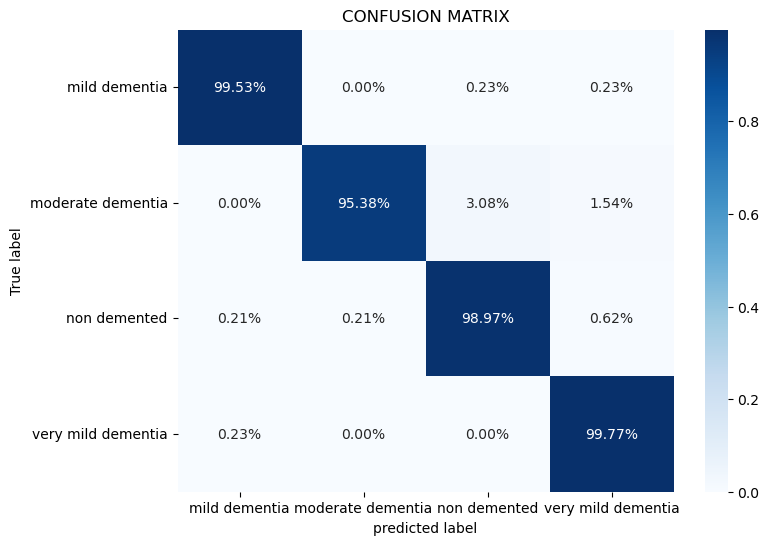

In [ ]:
c_matrix = confusion_matrix(r_all_labels, r_all_predictions)
c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix_percentage, annot=True, cmap="Blues", fmt=".2%", cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.title("CONFUSION MATRIX")
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

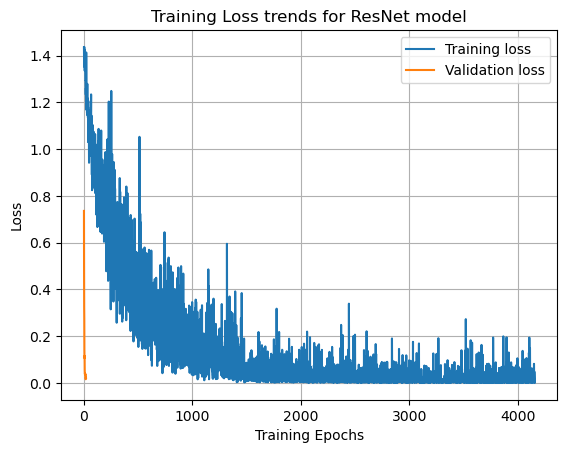

In [ ]:
# plot loss progress
plt.title("Training Loss trends for ResNet model")
plt.plot(r_train_losses, label = "Training loss")
plt.plot(r_val_losses, label = "Validation loss")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

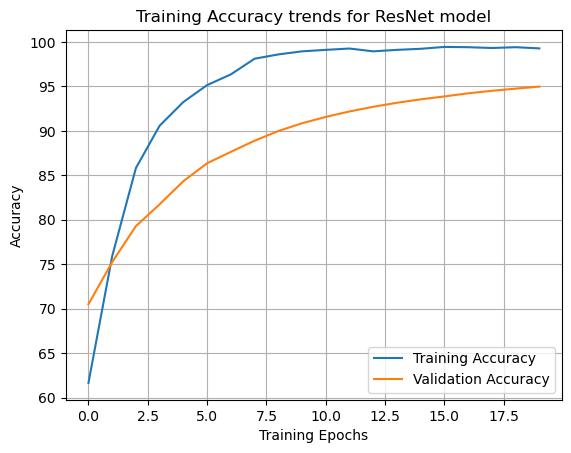

In [ ]:
# plot accuracy progress
plt.title("Training Accuracy trends for ResNet model")
plt.plot(r_accuracy_values, label = "Training Accuracy")
plt.plot(r_accuracy_val_values, label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# ALEXNET

In [27]:
import torch.nn.init as init

class AlexNetModel(nn.Module):
    """This class calls the AlexNet model from the PyTorch library, fine-tunes it for the specified number of classes, and outputs the tuned model."""
    def __init__(self, num_classes):
        super(AlexNetModel, self).__init__()

        # Load the pre-trained AlexNet model
        self.alexnet = models.alexnet(pretrained=True)



        conv = nn.Conv2d(
            in_channels=1,  # Grayscale images have 1 channel
            out_channels=self.alexnet.features[0].out_channels,  # Keep the same number of output channels
            kernel_size=self.alexnet.features[0].kernel_size,
            stride=self.alexnet.features[0].stride,
            padding=self.alexnet.features[0].padding,
            bias=self.alexnet.features[0].bias is not None
        )

        init.kaiming_normal_(conv.weight, mode='fan_out', nonlinearity='relu')
        if conv.bias is not None:
            init.constant_(conv.bias, 0)

        # Modify the first convolutional layer to accept a single channel (grayscale
        self.alexnet.features[0] = conv

        # Allow gradient updates for all parameters in the model
        for param in self.alexnet.parameters():
            param.requires_grad = True

        # Get the number of input features for the final fully connected layer
        in_features = self.alexnet.classifier[6].in_features

        # Replace the final fully connected layer with a new one to match num_classes
        self.alexnet.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.alexnet(x)

#### INSTANTIATE THE ALEXNET MODEL

In [28]:
model = AlexNetModel(num_classes)

In [29]:
model.to(device)

AlexNetModel(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
  

### ALEXNET TRAINING

In [30]:
# Experiment with different learning rates
learning_rate = 1e-4  # Try a higher learning rate initially

# Adjust batch size if memory permits
BATCH_SIZE = 64  # Try increasing the batch size

# Consider using different optimizers
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
# The training loop is a pytorch convention, here the train and validation loaders are trained and tested using early stoppings
#Storing the loss and accuracy value for each epoch
a_train_losses = []
a_accuracy_values = []

# validation items
a_val_correct = 0
a_val_total = 0
a_val_losses = []
a_accuracy_val_values = []

# EARLY STOPPING PARAMETERS(Early stopping for managing overfitting)
patience = 5
best_val_loss = float("inf")
current_patience = 0

for epoch in range(NUM_EPOCHS):
    a_train_loss = 0.0
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    #initializing the prediction count to zero before the loop
    a_correct = 0
    a_total = 0
    for batch_idx, (inputs, labels) in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        #get data to cuda if possible
        inputs = inputs.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.long)

        # forward pass
        # optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #This code accumulates training loss, stores loss values for each batch
        a_train_loss += loss.item()
        a_train_losses.append(loss.item())

        # get prediction
        _, predicted = torch.max(outputs, dim=1)
        a_total += labels.size(0)
        a_correct += (predicted == labels).sum().item()

        #back propagation
        loss.backward()

        # gradient descent
        optimizer.step()
        optimizer.zero_grad()

    # update learning rate scheduler
    scheduler.step()

    train_loss = a_train_loss / len(train_dataloader)
    print('Epoch {} loss: {:.3f}'.format(epoch + 1, train_loss))
    a_train_accuracy = 100 * (a_correct / a_total)
    a_accuracy_values.append(a_train_accuracy)

    # validation loop
    model.eval()

    with torch.no_grad():
        a_val_loss = 0.0

        for batch_idx, (inputs, labels) in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
            inputs = inputs.to(device, dtype = torch.float32)
            labels = labels.to(device, dtype = torch.long)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # get loss
            a_val_loss += loss.item()

            # get prediction
            _, predicted = torch.max(outputs, dim=1)
            a_val_total += labels.size(0)
            a_val_correct += (predicted == labels).sum().item()

        # Calculate the average validation loss after the loop
        a_val_loss /= len(val_dataloader)

        # Check improvement
        if a_val_loss < best_val_loss:
            best_val_loss = a_val_loss
            current_patience = 0
        else:
            current_patience += 1

        # Print accuracy and check for early stopping
        a_val_accuracy = 100 * (a_val_correct / a_val_total)
        # store accuracy values
        a_accuracy_val_values.append(a_val_accuracy)
        # store validation loss outside the loop
        a_val_losses.append(a_val_loss)

        print(f"Epoch {epoch + 1}, Training Accuracy: {a_train_accuracy:.2f}%, Validation Accuracy: {a_val_accuracy:.2f}%, Loss: {train_loss:.4f}, Validation Loss: {a_val_loss:.4f}")

        # If early stopping criteria met
        if current_patience >= patience:
            print(f"Early stopping after {epoch + 1} epochs.")
            break

Epoch [1/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 1 loss: 1.141


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1, Training Accuracy: 42.84%, Validation Accuracy: 53.86%, Loss: 1.1409, Validation Loss: 1.1126
Epoch [2/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 2 loss: 0.940


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2, Training Accuracy: 57.81%, Validation Accuracy: 59.52%, Loss: 0.9403, Validation Loss: 0.7919
Epoch [3/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 3 loss: 0.734


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3, Training Accuracy: 69.78%, Validation Accuracy: 63.51%, Loss: 0.7340, Validation Loss: 0.7685
Epoch [4/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 4 loss: 0.539


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4, Training Accuracy: 78.71%, Validation Accuracy: 68.36%, Loss: 0.5392, Validation Loss: 0.4253
Epoch [5/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 5 loss: 0.400


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5, Training Accuracy: 84.75%, Validation Accuracy: 70.28%, Loss: 0.3996, Validation Loss: 0.5330
Epoch [6/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 6 loss: 0.296


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6, Training Accuracy: 88.74%, Validation Accuracy: 73.22%, Loss: 0.2962, Validation Loss: 0.3284
Epoch [7/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 7 loss: 0.231


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7, Training Accuracy: 91.81%, Validation Accuracy: 75.61%, Loss: 0.2305, Validation Loss: 0.2539
Epoch [8/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 8 loss: 0.104


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8, Training Accuracy: 96.52%, Validation Accuracy: 78.26%, Loss: 0.1037, Validation Loss: 0.0981
Epoch [9/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 9 loss: 0.077


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9, Training Accuracy: 97.44%, Validation Accuracy: 80.38%, Loss: 0.0774, Validation Loss: 0.0860
Epoch [10/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 10 loss: 0.069


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10, Training Accuracy: 97.85%, Validation Accuracy: 82.11%, Loss: 0.0686, Validation Loss: 0.0653
Epoch [11/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 11 loss: 0.057


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11, Training Accuracy: 98.33%, Validation Accuracy: 83.53%, Loss: 0.0574, Validation Loss: 0.0708
Epoch [12/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 12 loss: 0.049


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 12, Training Accuracy: 98.51%, Validation Accuracy: 84.74%, Loss: 0.0491, Validation Loss: 0.0597
Epoch [13/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 13 loss: 0.049


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 13, Training Accuracy: 98.49%, Validation Accuracy: 85.76%, Loss: 0.0485, Validation Loss: 0.0618
Epoch [14/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 14 loss: 0.046


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 14, Training Accuracy: 98.61%, Validation Accuracy: 86.69%, Loss: 0.0462, Validation Loss: 0.0458
Epoch [15/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 15 loss: 0.037


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 15, Training Accuracy: 98.89%, Validation Accuracy: 87.47%, Loss: 0.0373, Validation Loss: 0.0511
Epoch [16/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 16 loss: 0.040


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 16, Training Accuracy: 98.98%, Validation Accuracy: 88.17%, Loss: 0.0400, Validation Loss: 0.0387
Epoch [17/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 17 loss: 0.035


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 17, Training Accuracy: 98.98%, Validation Accuracy: 88.80%, Loss: 0.0353, Validation Loss: 0.0448
Epoch [18/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 18 loss: 0.037


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 18, Training Accuracy: 98.83%, Validation Accuracy: 89.33%, Loss: 0.0371, Validation Loss: 0.0562
Epoch [19/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 19 loss: 0.033


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 19, Training Accuracy: 99.14%, Validation Accuracy: 89.80%, Loss: 0.0331, Validation Loss: 0.0479
Epoch [20/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 20 loss: 0.035


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 20, Training Accuracy: 98.81%, Validation Accuracy: 90.26%, Loss: 0.0350, Validation Loss: 0.0342


### ALEXNET TESTING

In [ ]:
# this is the pytorch testing loop convention
# initialize the total sample count and correct prediction count to zero
a_correct_pred = 0.0
a_total_samples = 0.0
# storing all the loss, predictions and label values for the test
a_test_losses = []
a_all_predictions = []
a_all_labels = []

model.eval()
with torch.no_grad():
    a_test_loss = 0.0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.long)

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # get loss
        a_test_loss += loss.item()
        #r_test_losses.append(r_test_loss)
        a_test_losses.append(loss.item())

        # get prediction
        _, predicted = torch.max(outputs, dim=1)
        a_total_samples += labels.size(0)

        # calculate accuracy
        a_correct_pred += (predicted == labels).sum()

        # get predicted and actual labels
        a_all_predictions.extend(predicted.cpu().numpy())
        a_all_labels.extend(labels.cpu().numpy())

a_test_loss /= len(test_dataloader.dataset)
accuracy = a_correct_pred / a_total_samples

# view loss and accuracy
print("Test Loss: {:.3f} | Accuracy: {:.3f}".format(a_test_loss, accuracy))

Test Loss: 0.001 | Accuracy: 0.991


#### RESULT FOR ALEXNET

In [ ]:
report = classification_report(a_all_labels, a_all_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       443
           1       0.96      0.98      0.97        65
           2       0.99      0.99      0.99       428
           3       0.99      0.99      0.99       487

    accuracy                           0.99      1423
   macro avg       0.98      0.99      0.99      1423
weighted avg       0.99      0.99      0.99      1423



In [ ]:
print(f"Accuracy: {accuracy * 100:.3f}%, precision: {precision * 100:.3f}%, recall: {recall * 100:.3f}%, F1: {f1 * 100:.3f}%")

Accuracy: 99.086%, precision: 99.093%, recall: 99.086%, F1: 99.088%


### ALEXNET RESULTS VISUALS

#### CONFUSION MATRIX

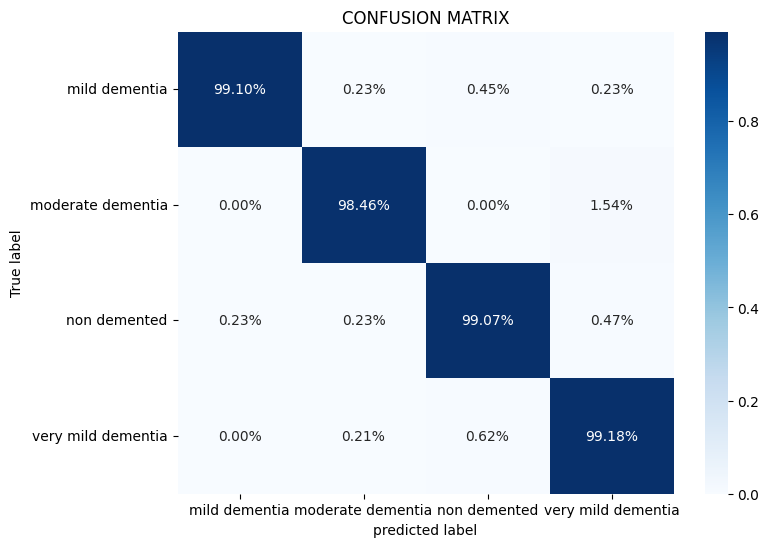

In [ ]:
c_matrix = confusion_matrix(a_all_labels, a_all_predictions)
c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix_percentage, annot=True, cmap="Blues", fmt=".2%", cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.title("CONFUSION MATRIX")
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

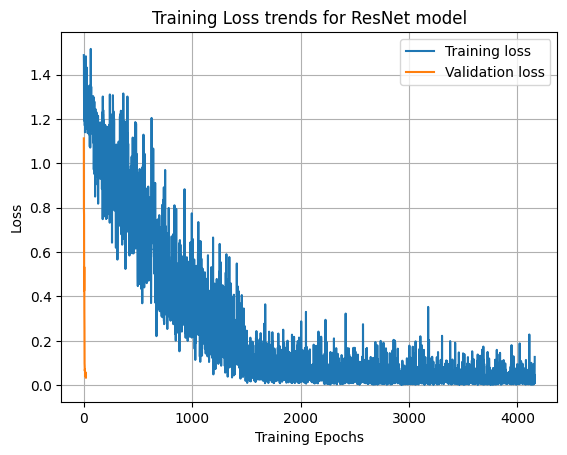

In [ ]:
# plot loss progress
plt.title("Training Loss trends for ResNet model")
plt.plot(a_train_losses, label = "Training loss")
plt.plot(a_val_losses, label = "Validation loss")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

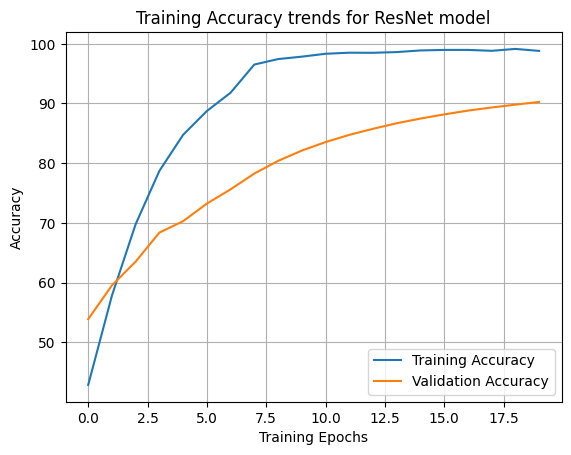

In [ ]:
# plot accuracy progress
plt.title("Training Accuracy trends for ResNet model")
plt.plot(a_accuracy_values, label = "Training Accuracy")
plt.plot(a_accuracy_val_values, label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

# CUSTOM CONVOLUTIONAL NEURAL NETWORK

In [ ]:
# prompt: make a more complex CNN architecture

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Added dropout for regularization
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(512, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 8 * 8)  # Adjust input size based on image dimensions
        x = self.dropout(x) # Apply dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x)
        return x

In [22]:
class ConvolutionNeuralNetwork(nn.Module):
    def __init__(self, in_channels = None,out_channels = None):
        super(ConvolutionNeuralNetwork, self). __init__()
        # input channel of 3 because it is a coloured image dataset
        # kernel size, stride and padding are parameters that can be changed but following a 3x3 kernel with same stride and padding
        # this is a convolution layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32))

        # convolution layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False))

        # adding a convolution pooling layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # convolution layer
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64))

        # activation function layer to add non linearity
        self.relu = nn.ReLU()

        # convolutional pooling layer
        self.avgpool = nn.AvgPool2d(7)
        # regulariration dropout
        self.dropout = nn.Dropout(0.5)

        # fully connected layer
        self.fc1 = nn.Linear(5184, num_classes)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.pool1(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

#### INSTANTIATE THE CNN

In [23]:
model2 = ConvolutionNeuralNetwork(num_classes)

In [24]:
model2.to(device)

ConvolutionNeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (avgpool): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5184, out_features=4, bias=True)
)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate_c)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# CNN TRAINING

In [26]:
# The training loop is a pytorch convention, here the train and validation set are trained and tested using early stoppings
#Storing the loss and accuracy value for each epoch
c_train_losses = []
c_accuracy_values = []

# validation items
c_val_correct = 0
c_val_total = 0
c_val_losses = []
c_accuracy_val_values = []

# EARLY STOPPING PARAMETERS(Early stopping for managing overfitting)
patience = 5
best_val_loss = float("inf")
current_patience = 0

for epoch in range(NUM_EPOCHS):
    c_train_loss = 0.0
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    #initializing the prediction count to zero before the loop
    c_correct = 0
    c_total = 0
    for batch_idx, (inputs, labels) in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        #get data to cuda if possible
        inputs = inputs.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.long)

        # forward pass
        # optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)

        # get losses
        c_train_loss += loss.item()
        c_train_losses.append(loss.item())

        _, predicted = torch.max(outputs, dim=1)
        c_total += labels.size(0)
        c_correct += (predicted == labels).sum().item()

        #back propagation
        loss.backward()

        # gradient descent
        optimizer.step()
        optimizer.zero_grad()

    # update learning rate scheduler
    scheduler.step()

    epoch_loss = c_train_loss / len(train_dataloader)
    print('Epoch {} loss: {:.3f}'.format(epoch + 1, epoch_loss))
    c_train_accuracy = 100 * (c_correct / c_total)
    c_accuracy_values.append(c_train_accuracy)

    # validation accuracy
    model2.eval()

    with torch.no_grad():
        c_val_loss = 0.0
        for batch_idx, (inputs, labels) in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
            inputs = inputs.to(device, dtype = torch.float32)
            labels = labels.to(device, dtype = torch.long)

            # forward pass
            outputs = model2(inputs)
            loss = criterion(outputs, labels)

            #get losses
            c_val_loss += loss.item()
            c_val_losses.append(loss.item())

            # get prediction
            _, predicted = torch.max(outputs, dim=1)
            c_val_total += labels.size(0)
            c_val_correct += (predicted == labels).sum().item()

        # Calculate the average validation loss after the loop
        c_val_loss /= len(val_dataloader)

        # Check improvement
        if c_val_loss < best_val_loss:
            best_val_loss = c_val_loss
            current_patience = 0
        else:
            current_patience += 1

        # Print accuracy and check for early stopping
        c_val_accuracy = 100 * (c_val_correct / c_val_total)
        # store accuracy values
        c_accuracy_val_values.append(c_val_accuracy)
        # store validation loss outside the loop
        c_val_losses.append(c_val_loss)

        print(f"Epoch {epoch + 1}, Training Accuracy: {c_train_accuracy:.2f}%, Validation Accuracy: {c_val_accuracy:.2f}%, Loss: {epoch_loss:.4f}, Validation Loss: {c_val_loss:.4f}")

        # If early stopping criteria met
        if current_patience >= patience:
            print(f"Early stopping after {epoch + 1} epochs.")
            break

Epoch [1/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 1 loss: 1.020


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1, Training Accuracy: 55.59%, Validation Accuracy: 60.18%, Loss: 1.0202, Validation Loss: 0.9121
Epoch [2/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 2 loss: 0.758


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 2, Training Accuracy: 69.57%, Validation Accuracy: 67.21%, Loss: 0.7577, Validation Loss: 0.6844
Epoch [3/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 3 loss: 0.608


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3, Training Accuracy: 76.15%, Validation Accuracy: 71.75%, Loss: 0.6082, Validation Loss: 0.5242
Epoch [4/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 4 loss: 0.494


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 4, Training Accuracy: 81.00%, Validation Accuracy: 73.86%, Loss: 0.4942, Validation Loss: 0.4803
Epoch [5/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 5 loss: 0.414


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5, Training Accuracy: 84.38%, Validation Accuracy: 76.07%, Loss: 0.4137, Validation Loss: 0.4040
Epoch [6/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 6 loss: 0.366


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6, Training Accuracy: 86.54%, Validation Accuracy: 78.03%, Loss: 0.3655, Validation Loss: 0.3238
Epoch [7/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 7 loss: 0.339


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7, Training Accuracy: 87.43%, Validation Accuracy: 79.29%, Loss: 0.3387, Validation Loss: 0.3308
Epoch [8/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 8 loss: 0.260


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8, Training Accuracy: 91.04%, Validation Accuracy: 80.90%, Loss: 0.2597, Validation Loss: 0.2483
Epoch [9/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 9 loss: 0.247


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9, Training Accuracy: 92.00%, Validation Accuracy: 81.98%, Loss: 0.2474, Validation Loss: 0.2606
Epoch [10/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 10 loss: 0.239


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10, Training Accuracy: 91.64%, Validation Accuracy: 82.85%, Loss: 0.2395, Validation Loss: 0.2458
Epoch [11/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 11 loss: 0.230


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11, Training Accuracy: 92.38%, Validation Accuracy: 83.57%, Loss: 0.2298, Validation Loss: 0.2453
Epoch [12/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 12 loss: 0.227


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 12, Training Accuracy: 92.31%, Validation Accuracy: 84.22%, Loss: 0.2268, Validation Loss: 0.2400
Epoch [13/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 13 loss: 0.227


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 13, Training Accuracy: 92.29%, Validation Accuracy: 84.85%, Loss: 0.2266, Validation Loss: 0.2456
Epoch [14/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 14 loss: 0.220


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 14, Training Accuracy: 92.29%, Validation Accuracy: 85.37%, Loss: 0.2199, Validation Loss: 0.2301
Epoch [15/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 15 loss: 0.203


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 15, Training Accuracy: 93.25%, Validation Accuracy: 85.84%, Loss: 0.2028, Validation Loss: 0.2296
Epoch [16/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 16 loss: 0.205


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 16, Training Accuracy: 93.28%, Validation Accuracy: 86.26%, Loss: 0.2050, Validation Loss: 0.2247
Epoch [17/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 17 loss: 0.205


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 17, Training Accuracy: 93.40%, Validation Accuracy: 86.64%, Loss: 0.2048, Validation Loss: 0.2224
Epoch [18/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 18 loss: 0.209


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 18, Training Accuracy: 93.16%, Validation Accuracy: 86.99%, Loss: 0.2093, Validation Loss: 0.2287
Epoch [19/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 19 loss: 0.201


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 19, Training Accuracy: 93.65%, Validation Accuracy: 87.28%, Loss: 0.2007, Validation Loss: 0.2203
Epoch [20/20]


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 20 loss: 0.206


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 20, Training Accuracy: 93.22%, Validation Accuracy: 87.55%, Loss: 0.2063, Validation Loss: 0.2146


## CNN TESTING

In [27]:
# this is the pytorch testing loop convention
c_correct_pred = 0.0
c_total_samples = 0.0
c_test_losses = []
c_all_predictions = []
c_all_labels = []

model2.eval()
with torch.no_grad():
    c_test_loss = 0.0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.long)

        # forward pass
        outputs = model2(inputs)
        loss = criterion(outputs, labels)

        # get loss
        c_test_loss += loss.item()
        #c_test_losses.append(c_test_loss)
        c_test_losses.append(loss.item())

        # get prediction
        _, predicted = torch.max(outputs, dim=1)
        c_total_samples += labels.size(0)

        # calculate accuracy
        c_correct_pred += (predicted == labels).sum()

        # get predicted and actual labels
        c_all_predictions.extend(predicted.cpu().numpy())
        c_all_labels.extend(labels.cpu().numpy())

c_test_loss /= len(test_dataloader.dataset)
accuracy = c_correct_pred / c_total_samples

# view loss and accuracy
print("Test Loss: {:.3f} | Accuracy: {:.3f}".format(c_test_loss, accuracy))

Test Loss: 0.007 | Accuracy: 0.926


In [28]:
# these are gotten from the sklearn library
accuracy = accuracy_score(c_all_labels, c_all_predictions)
precision = precision_score(c_all_labels, c_all_predictions, average = "weighted")
recall = recall_score(c_all_labels, c_all_predictions, average = "weighted")
f1 = f1_score(c_all_labels, c_all_predictions, average = "weighted")

In [29]:
report = classification_report(c_all_labels, c_all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       443
           1       0.96      0.80      0.87        86
           2       0.91      0.94      0.93       466
           3       0.92      0.91      0.92       428

    accuracy                           0.93      1423
   macro avg       0.93      0.90      0.92      1423
weighted avg       0.93      0.93      0.93      1423



In [30]:
print(f"Accuracy: {accuracy * 100:.3f}%, precision: {precision * 100:.3f}%, recall: {recall * 100:.3f}%, F1: {f1 * 100:.3f}%")

Accuracy: 92.621%, precision: 92.678%, recall: 92.621%, F1: 92.595%


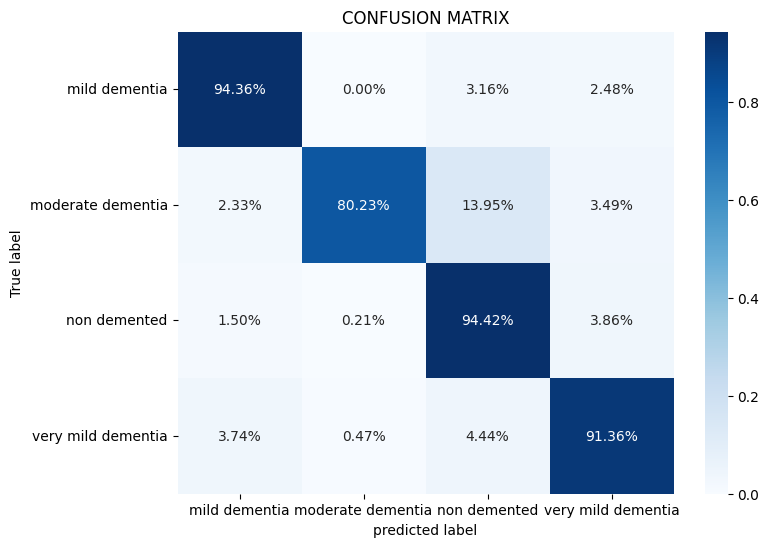

In [31]:
c_matrix = confusion_matrix(c_all_labels, c_all_predictions)
c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix_percentage, annot=True, cmap="Blues", fmt=".2%", cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.title("CONFUSION MATRIX")
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

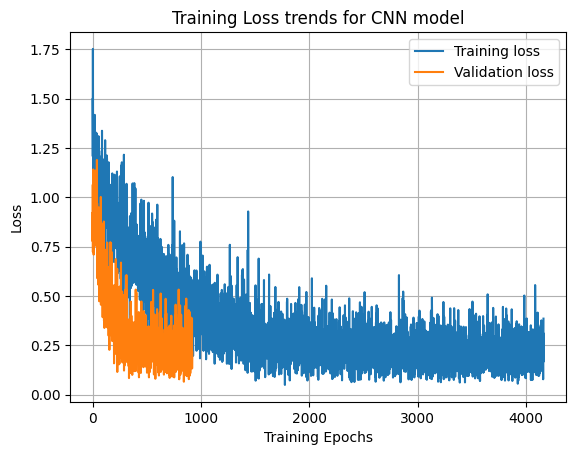

In [32]:
# plot loss progress
plt.title("Training Loss trends for CNN model")
plt.plot(c_train_losses, label = "Training loss")
plt.plot(c_val_losses, label = "Validation loss")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

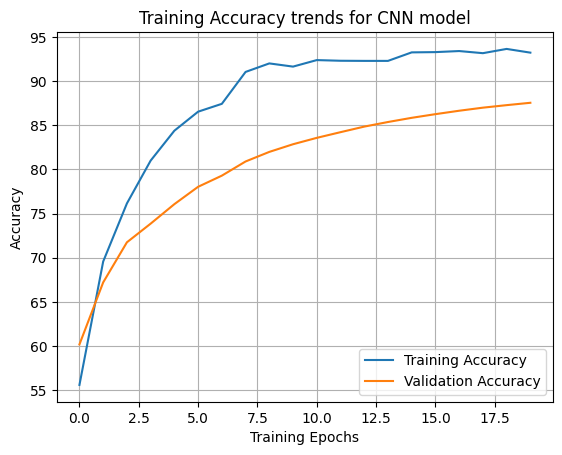

In [33]:
# plot accuracy progress
plt.title("Training Accuracy trends for CNN model")
plt.plot(c_accuracy_values, label = "Training Accuracy")
plt.plot(c_accuracy_val_values, label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()